# 6. Factor Analysis & WALS Validation

**Summary**: Analyzes correlations between computed factors and validates results against WALS feature 83A (Order of Object and Verb).

**Key Steps**:
1. Analyze correlations between HCS factors and Head-Initiality.
2. Validate VO/OV classification against WALS data.
3. Visualize distributions of factors.

**Inputs**:
- `data/hcs_factors.csv`
- `data/vo_vs_hi_scores.csv`
- WALS data (internal/online)

**Outputs**:
- Validation scatter plots and boxplots.

**Runtime**: ~1 minute

---

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from importlib import reload

# Custom modules
import data_utils
import compute_factors
import plotting

# Reload modules
reload(data_utils)
reload(compute_factors)
reload(plotting)

# Configuration
DATA_DIR = "data"
OUTPUT_DIR = "data"

# 1. Load Data
print("Loading metadata and processed data...")
metadata = data_utils.load_metadata(os.path.join(DATA_DIR, 'metadata.pkl'))
langNames = metadata['langNames']
langnameGroup = metadata['langnameGroup']

# Load average sizes
with open(os.path.join(DATA_DIR, 'all_langs_average_sizes_filtered.pkl'), 'rb') as f:
    all_langs_average_sizes_filtered = pickle.load(f)

# Load factor files if they exist
try:
    hcs_df = pd.read_csv(os.path.join(OUTPUT_DIR, 'hcs_factors.csv'))
    print("Loaded hcs_factors.csv")
except FileNotFoundError:
    hcs_df = pd.DataFrame()

try:
    vo_hi_df = pd.read_csv(os.path.join(OUTPUT_DIR, 'vo_vs_hi_scores.csv'))
    print("Loaded vo_vs_hi_scores.csv")
except FileNotFoundError:
    vo_hi_df = pd.DataFrame()
    
# Setup palette
groups = sorted(list(set(langnameGroup.values())))
group_to_color = {grp: plt.cm.tab20(i % 20) for i, grp in enumerate(groups)}
group_to_color['Other'] = 'gray'

Loading metadata and processed data...
Loaded metadata from data/metadata.pkl
Loaded hcs_factors.csv
Loaded vo_vs_hi_scores.csv


## 1. Head-Initiality vs VO Score

Analyzing the relationship between the general Head-Initiality score (calculated across all dependency types) and the specific VO score (calculated only on object dependencies).

Mapping Language Groups. approximately 1 min 30...
Plotting Head-Initiality vs VO Score for 185 languages


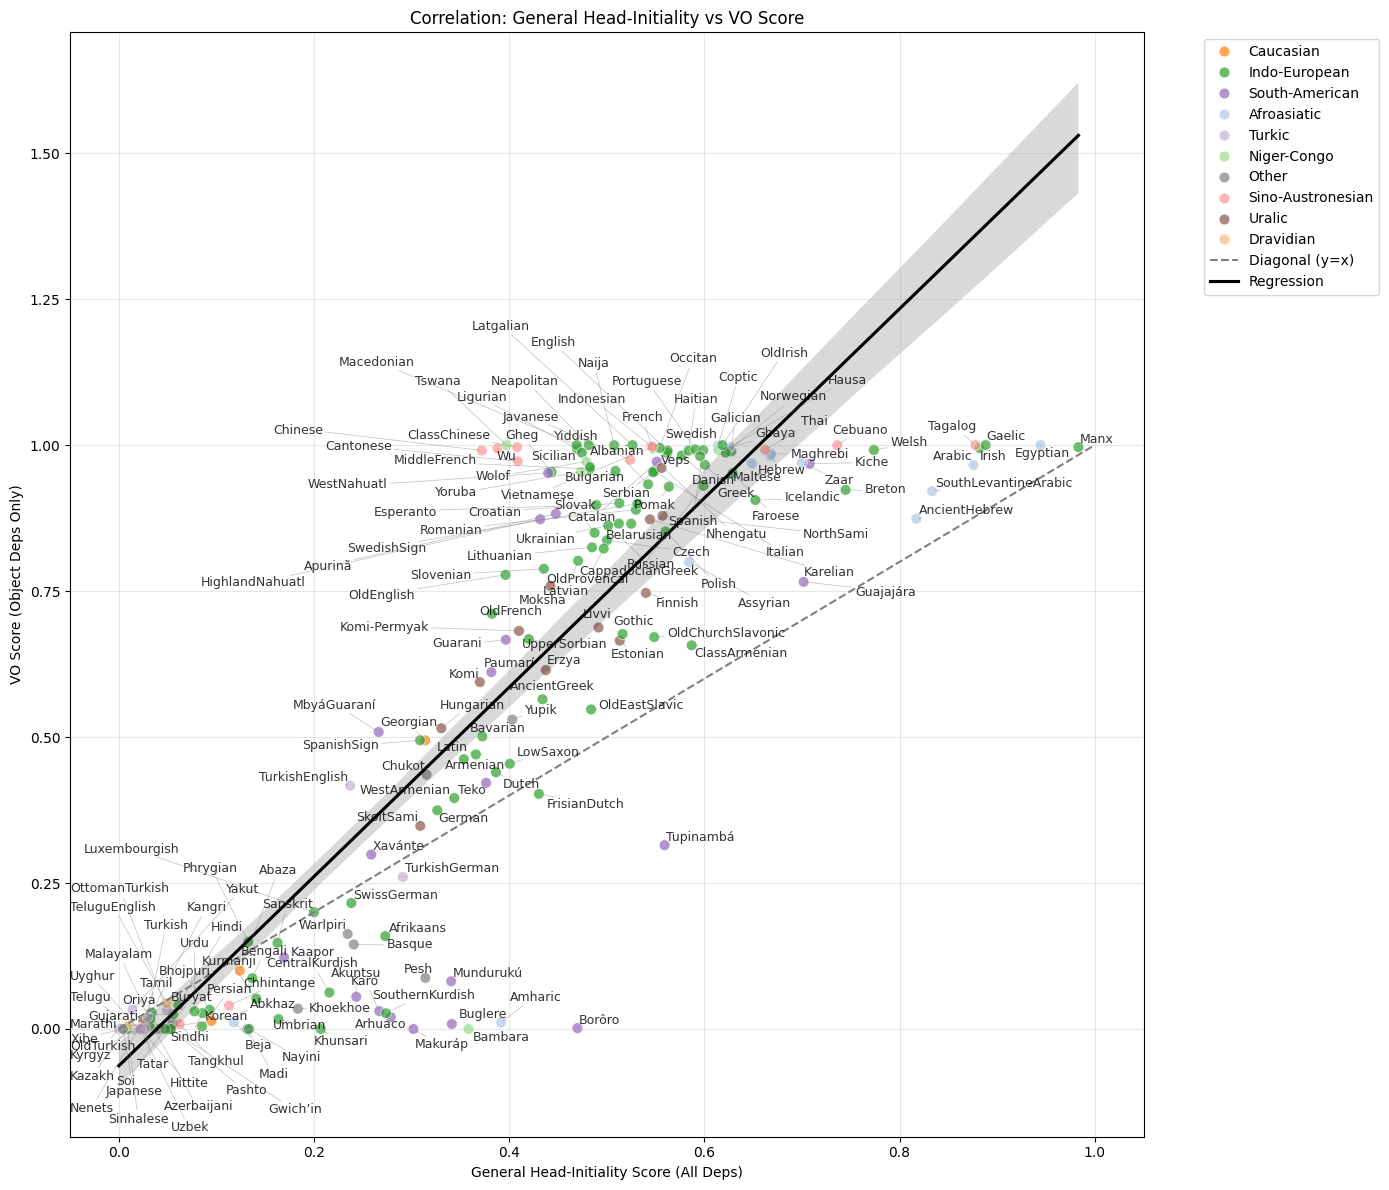

In [2]:
print("Mapping Language Groups. approximately 1 min 30...")
if 'vo_hi_df' in locals() and not vo_hi_df.empty:
    # Ensure mapping
    vo_hi_df['language_name'] = vo_hi_df['language_code'].map(langNames)
    vo_hi_df['group'] = vo_hi_df['language_name'].map(langnameGroup)
    
    # Filter valid data
    plot_df = vo_hi_df.dropna(subset=['vo_score', 'head_initiality_score'])
    
    print(f"Plotting Head-Initiality vs VO Score for {len(plot_df)} languages")
    
    # Plot with diagonal and regression
    plotting.plot_scatter_2d(
        plot_df, 
        x_col='head_initiality_score', 
        y_col='vo_score', 
        group_col='group', 
        appearance_dict=group_to_color,
        title='Correlation: General Head-Initiality vs VO Score', 
        xlabel='General Head-Initiality Score (All Deps)', 
        ylabel='VO Score (Object Deps Only)', 
        figsize=(14, 12),
        label_col='language_name',
        add_diagonal=True,
        add_regression=True
    )
else:
    print("Error: vo_hi_df not found or empty.")

## 2. Diagonal Factor vs VO Score

Analyzing the relationship between the Diagonal Factor (ratio of Right2/Left2 sizes) and the VO Score.

this takes around 1 minute 45
Plotting Diagonal Factor vs VO Score for 170 languages


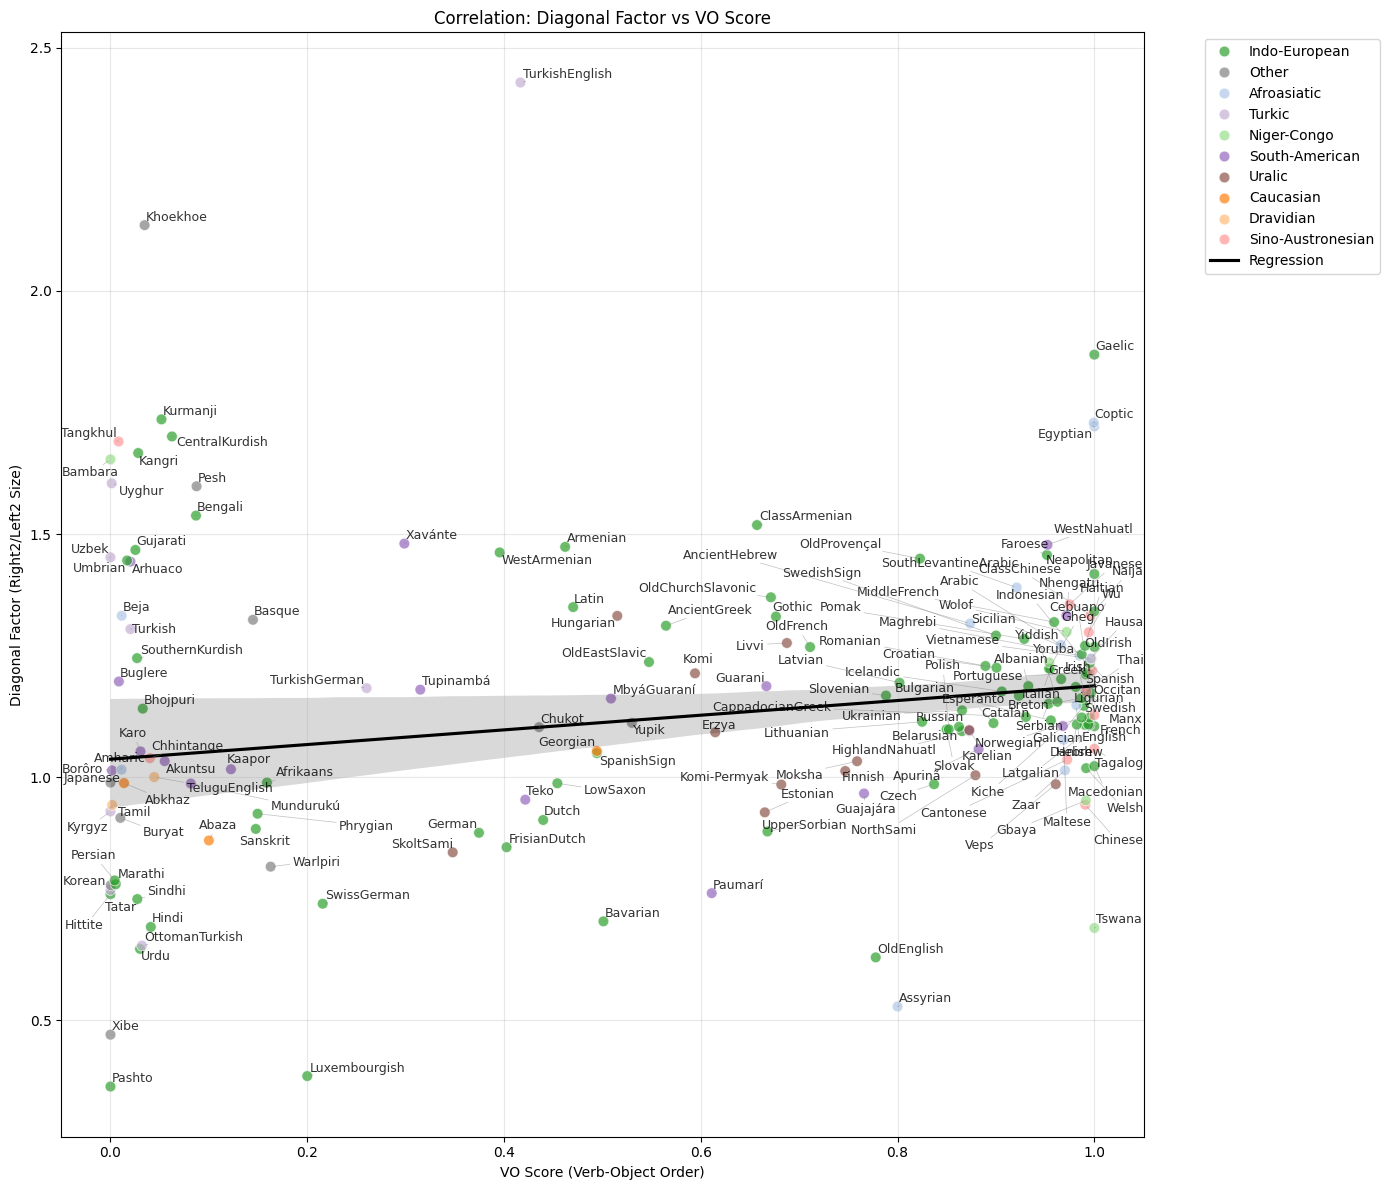

In [3]:
import compute_factors
from importlib import reload
reload(compute_factors)

print("this takes around 1 minute 45")

# 1. Compute/Load Diagonal Factors
diag_df = compute_factors.compute_diagonal_factors(all_langs_average_sizes_filtered, langNames, langnameGroup)

# 2. Merge with VO Scores
if 'vo_hi_df' in locals() and not vo_hi_df.empty:
    # Use 'language' from vo_hi_df and 'language_code' from diag_df to merge
    # Note: vo_hi_df uses 'language' which corresponds to 'language_code' in others
    merged_diag = pd.merge(
        diag_df, 
        vo_hi_df[['language_code', 'vo_score']], 
        left_on='language_code', 
        right_on='language_code', 
        how='inner'
    )

    print(f"Plotting Diagonal Factor vs VO Score for {len(merged_diag)} languages")

    # 3. Plot
    plotting.plot_scatter_2d(
        merged_diag, 
        x_col='vo_score', 
        y_col='diagonal_factor', 
        group_col='group', 
        appearance_dict=group_to_color,
        title='Correlation: Diagonal Factor vs VO Score', 
        xlabel='VO Score (Verb-Object Order)', 
        ylabel='Diagonal Factor (Right2/Left2 Size)', 
        figsize=(14, 12),
        label_col='language_name',
        add_diagonal=False,
        add_regression=True
    )
else:
    print("Error: vo_hi_df is missing, cannot compare diagonal factors to VO score.")

# WALS

## 3. WALS Validation: Feature 83A (Order of Object and Verb)

We validate our computed **VO Score** against the expert-annotated **WALS Feature 83A**.
This checks if our corpus-derived metrics align with typological classifications.

In [4]:
# Load WALS data: Local Cache + CamelCase Splitting + Manual Mapping
import pandas as pd
import plotting
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import re
import requests
from importlib import reload
reload(plotting)

# Ensure plots directory exists
PLOTS_DIR = 'plots'
if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)

# Ensure WALS data directory exists
WALS_DIR = 'data/wals'
if not os.path.exists(WALS_DIR):
    os.makedirs(WALS_DIR)

def download_if_not_exists(url, filename):
    filepath = os.path.join(WALS_DIR, filename)
    if not os.path.exists(filepath):
        print(f"Downloading {filename}...")
        try:
            response = requests.get(url)
            response.raise_for_status()
            with open(filepath, 'w') as f:
                f.write(response.text)
        except Exception as e:
            print(f"Failed to download {filename}: {e}")
            return None
    return filepath

def split_camel_case(name):
    if not isinstance(name, str): return name
    # Insert space before capital letters (that are not at the start)
    return re.sub(r'(?<!^)(?=[A-Z])', ' ', name)

try:
    print("Loading WALS Classification data...")
    # 1. Load Languages, Values, and Codes (Local Cache)
    base_url = 'https://raw.githubusercontent.com/cldf-datasets/wals/master/cldf/'
    
    langs_file = download_if_not_exists(base_url + 'languages.csv', 'languages.csv')
    values_file = download_if_not_exists(base_url + 'values.csv', 'values.csv')
    codes_file = download_if_not_exists(base_url + 'codes.csv', 'codes.csv')
    
    if langs_file and values_file and codes_file:
        wals_langs = pd.read_csv(langs_file)
        wals_langs = wals_langs[['ID', 'Name', 'ISO639P3code']]

        # 2. Load Codes (Labels)
        wals_codes = pd.read_csv(codes_file)
        wals_83a_codes = wals_codes[wals_codes['Parameter_ID'] == '83A'][['ID', 'Name']].rename(columns={'Name': 'Label', 'ID': 'Code_ID'})
        
        # 3. Filter for Feature 83A
        wals_values = pd.read_csv(values_file)
        wals_83a = wals_values[wals_values['Parameter_ID'] == '83A'].copy()
        
        comparison_df = pd.DataFrame()
        
        if not wals_83a.empty:
            # Map Code_ID to Label
            wals_83a = pd.merge(wals_83a, wals_83a_codes, on='Code_ID', how='left')
            
            # 4. Merge Information
            wals_merged = pd.merge(wals_83a, wals_langs, left_on='Language_ID', right_on='ID', how='inner')
            
            # 5. Integrate with Our Data (vo_hi_df)
            if 'vo_hi_df' in locals() and not vo_hi_df.empty:
                vo_hi_df['language_name_map'] = vo_hi_df['language_code'].map(langNames)
                vo_hi_df['clean_name'] = vo_hi_df['language_name_map'].apply(split_camel_case)
                
                # --- STRATEGY 4: Manual Mapping ---
                iso_manual_map = {
                    'zh': 'Mandarin',
                    'yue': 'Cantonese',
                    'ar': 'Arabic (Modern Standard)',
                    'hy': 'Armenian (Eastern)',
                    'hr': 'Serbian-Croatian',
                    'sr': 'Serbian-Croatian',
                    'bs': 'Serbian-Croatian',
                    'el': 'Greek (Modern)',
                    'he': 'Hebrew (Modern)',
                    'gd': 'Gaelic (Scots)',
                    'gsw': 'German (Zürich)', 
                }
                
                # Apply manual map
                vo_hi_df['manual_wals_name'] = vo_hi_df['language_code'].map(iso_manual_map)
                
                # Dual Matching Strategy (Updated)
                # Strategy 1: ISO Code
                df_iso = pd.merge(vo_hi_df, wals_merged[['ISO639P3code', 'Label', 'Name', 'Language_ID']], 
                                  left_on='language_code', right_on='ISO639P3code', how='inner')
                
                # Strategy 2: Original Name
                df_name = pd.merge(vo_hi_df, wals_merged[['Name', 'Label', 'Language_ID']], 
                                   left_on='language_name_map', right_on='Name', how='inner')
                
                # Strategy 3: Clean Name (Split CamelCase)
                df_clean_name = pd.merge(vo_hi_df, wals_merged[['Name', 'Label', 'Language_ID']], 
                                         left_on='clean_name', right_on='Name', how='inner')
                                         
                # Strategy 4: Manual Mapping
                df_manual = pd.merge(vo_hi_df, wals_merged[['Name', 'Label', 'Language_ID']], 
                                     left_on='manual_wals_name', right_on='Name', how='inner')
                
                # Combine all matches
                comparison_df = pd.concat([df_iso, df_name, df_clean_name, df_manual]).drop_duplicates(subset=['language_code'])
                
                # Ensure Name column is populated
                if 'Name' in comparison_df.columns:
                     comparison_df['Name'] = comparison_df['Name'].fillna(comparison_df['language_name_map'])
                elif 'language_name_map' in comparison_df.columns:
                     comparison_df['Name'] = comparison_df['language_name_map']
                
                print(f"Found WALS 83A data for {len(comparison_df)} languages (ISO+Name+CleanName+Manual).")
                
                # --- Diagnostics for Unmatched Languages ---
                matched_langs = set(comparison_df['language_code'])
                unmatched_df = vo_hi_df[~vo_hi_df['language_code'].isin(matched_langs)][['language_code', 'language_name_map', 'clean_name']].copy()
                unmatched_df['Reason'] = 'No match found'
                
                print(f"\n--- Unmatched Languages from Our Dataset ({len(unmatched_df)}) ---")
                print(unmatched_df.to_string())

                # Unused WALS languages
                matched_wals_ids = set()
                if 'Language_ID' in comparison_df.columns:
                     matched_wals_ids.update(comparison_df['Language_ID'].dropna())
                
                unused_wals = wals_merged[~wals_merged['Language_ID'].isin(matched_wals_ids)][['Language_ID', 'Name', 'ISO639P3code', 'Label']]
                print(f"\n--- Available WALS 83A Languages NOT Matched ({len(unused_wals)}) ---")
                print(unused_wals.head(50).to_string())
                print("... (Total unused: {})".format(len(unused_wals)))
                
            else:
                print("vo_hi_df not available for comparison.")
    else:
         print("Failed to load WALS data files.")
        
except Exception as e:
    print(f"WALS Analysis Skipped: {e}")
    import traceback
    traceback.print_exc()


Loading WALS Classification data...
Found WALS 83A data for 94 languages (ISO+Name+CleanName+Manual).

--- Unmatched Languages from Our Dataset (91) ---
    language_code     language_name_map              clean_name          Reason
0             abq                 Abaza                   Abaza  No match found
2              af             Afrikaans               Afrikaans  No match found
3             aqz               Akuntsu                 Akuntsu  No match found
5             gsw           SwissGerman            Swiss German  No match found
7             grc          AncientGreek           Ancient Greek  No match found
8             hbo         AncientHebrew          Ancient Hebrew  No match found
12            aii              Assyrian                Assyrian  No match found
16            bar              Bavarian                Bavarian  No match found
18             be            Belarusian              Belarusian  No match found
21            sab               Buglere        

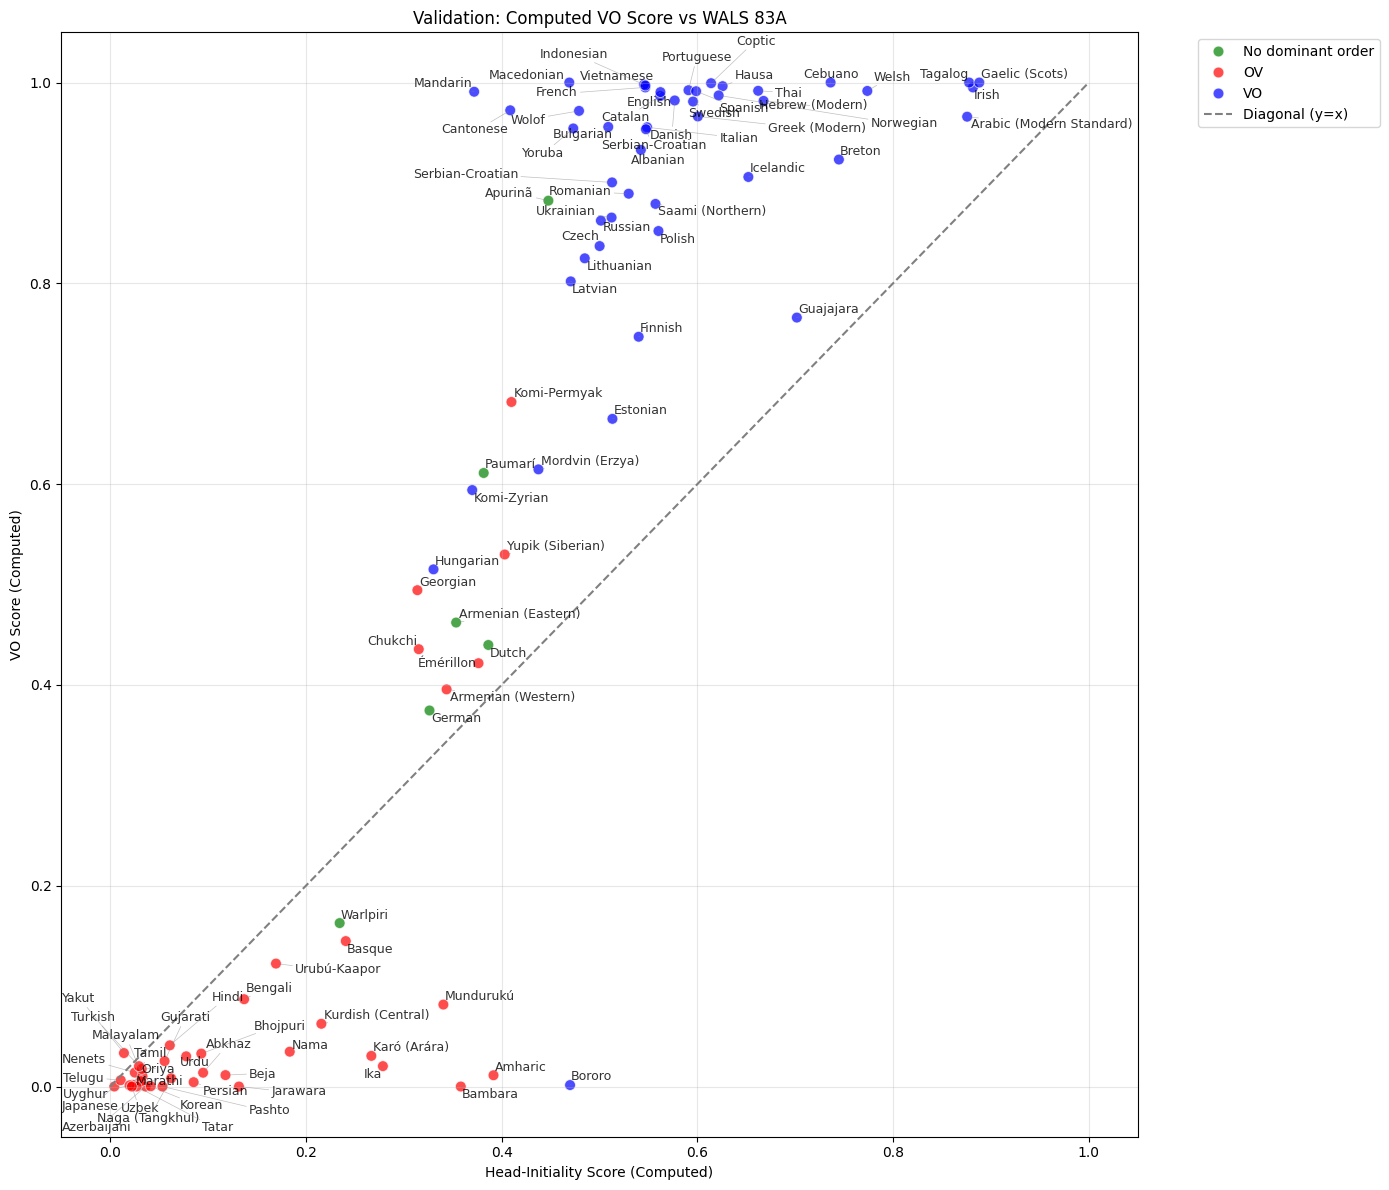

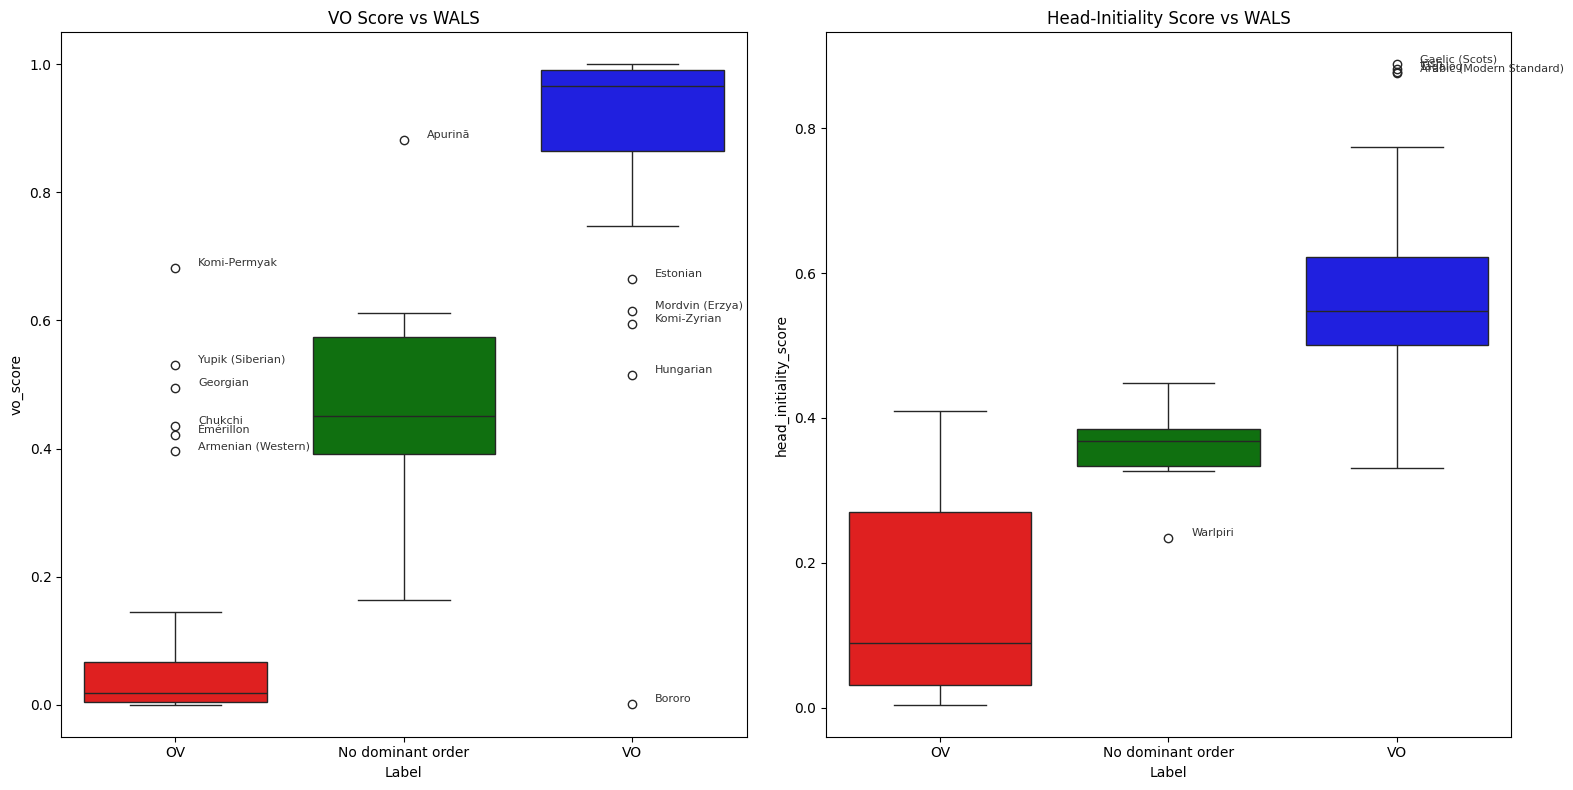

In [5]:
# Plotting WALS Analysis
try:
    if 'comparison_df' in locals() and not comparison_df.empty:
        # --- Customizations ---
        
        # 1. Colors (Green for No dominant order)
        wals_colors = {
            'OV': 'red',
            'VO': 'blue',
            'No dominant order': 'green'
        }
        present_labels = comparison_df['Label'].unique()
        current_palette = {k: v for k, v in wals_colors.items() if k in present_labels}
        
        # 2. Scatter Plot: Label ALL languages
        plotting.plot_scatter_2d(
            comparison_df, 
            x_col='head_initiality_score',
            y_col='vo_score', 
            group_col='Label', 
            appearance_dict=current_palette,
            title='Validation: Computed VO Score vs WALS 83A',
            xlabel='Head-Initiality Score (Computed)', 
            ylabel='VO Score (Computed)', 
            figsize=(14, 12), 
            label_col='Name',
            add_diagonal=True,
            add_regression=False
        )
        
        # 3. Two Boxplots with Outlier Labeling
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
        
        # Define Specific Order: OV, No dominant order, VO
        desired_order = ['OV', 'No dominant order', 'VO']
        plot_order = [label for label in desired_order if label in present_labels]

        # Right plot: Head-Init
        sns.boxplot(data=comparison_df, x='Label', y='head_initiality_score', order=plot_order, hue='Label', palette=current_palette, ax=axes[1], legend=False)
        axes[1].set_title('Head-Initiality Score vs WALS')
        
        # Label outliers manually - Up and to the Right
        for i, label in enumerate(plot_order):
            subset = comparison_df[comparison_df['Label'] == label]
            if subset.empty: continue
            
            y_col = 'head_initiality_score'
            q1 = subset[y_col].quantile(0.25)
            q3 = subset[y_col].quantile(0.75)
            iqr = q3 - q1
            outliers = subset[(subset[y_col] < (q1 - 1.5 * iqr)) | (subset[y_col] > (q3 + 1.5 * iqr))]
            
            for _, row in outliers.iterrows():
                x_pos = i + 0.1 
                y_pos = row[y_col]
                axes[1].text(x_pos, y_pos, row['Name'], ha='left', va='bottom', fontsize=8, color='#333333')

        # Left plot: VO Score
        sns.boxplot(data=comparison_df, x='Label', y='vo_score', order=plot_order, hue='Label', palette=current_palette, ax=axes[0], legend=False)
        axes[0].set_title('VO Score vs WALS')
        
        for i, label in enumerate(plot_order):
            subset = comparison_df[comparison_df['Label'] == label]
            if subset.empty: continue
            
            y_col = 'vo_score'
            q1 = subset[y_col].quantile(0.25)
            q3 = subset[y_col].quantile(0.75)
            iqr = q3 - q1
            outliers = subset[(subset[y_col] < (q1 - 1.5 * iqr)) | (subset[y_col] > (q3 + 1.5 * iqr))]
            
            for _, row in outliers.iterrows():
                x_pos = i + 0.1
                y_pos = row[y_col]
                axes[0].text(x_pos, y_pos, row['Name'], ha='left', va='bottom', fontsize=8, color='#333333')

        plt.tight_layout()
        plt.savefig(os.path.join(PLOTS_DIR, 'wals_validation_boxplots_combined.png'))
        plt.show()
    else:
        print("No comparison data available for plotting.")
except Exception as e:
    print(f"Plotting Error: {e}")
    import traceback
    traceback.print_exc()


--- Statistical Alignment Analysis ---


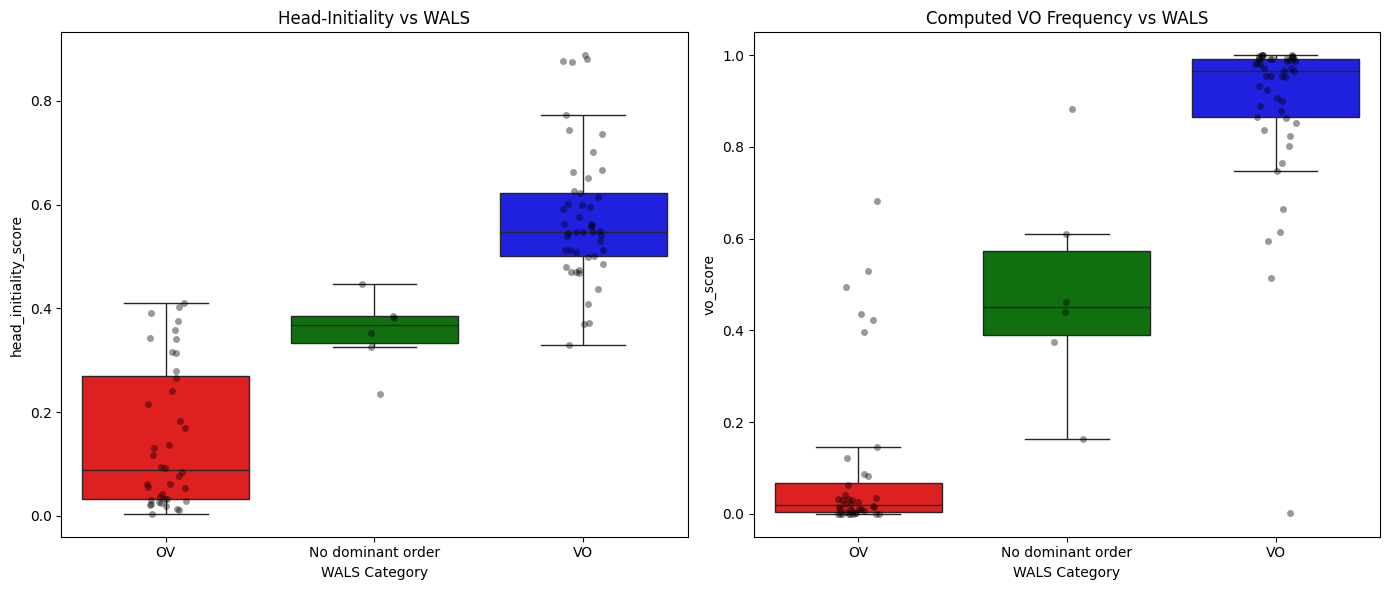


--- Comparative Alignment Metrics ---
              Measure  F-Statistic  p-value  Eta-Squared  Separation (VO-OV)  Avg Within-Group SD  SD (OV)  SD (VO)  SD (NoDom)
head_initiality_score   117.450831 6.18e-26     0.720775            0.428703             0.112948 0.136644 0.130559    0.071641
             vo_score   213.409431 4.38e-35     0.824263            0.798425             0.198167 0.176202 0.176517    0.241783


In [6]:
# Statistical Comparison: Head-Initiality vs VO Frequency
import scipy.stats as stats

if 'comparison_df' in locals() and not comparison_df.empty:
    print("--- Statistical Alignment Analysis ---")
    
    # Prepare Data
    # Ensure we have the necessary columns
    measures = ['head_initiality_score', 'vo_score']
    wals_col = 'Label'
    
    # Define Specific Order: OV, No dominant order, VO
    # This order is used for both Boxplot and Stripplot
    groups = ['OV', 'No dominant order', 'VO']
    valid_df = comparison_df[comparison_df[wals_col].isin(groups)].copy()
    
    # 1. Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    titles = {
        'head_initiality_score': 'Head-Initiality vs WALS',
        'vo_score': 'Computed VO Frequency vs WALS'
    }
    
    # Colors from wals_colors if available, else default
    # Re-define locally just in case
    my_pal = {'OV': 'red', 'VO': 'blue', 'No dominant order': 'green'}
    
    for i, measure in enumerate(measures):
        ax = axes[i]
        
        # Boxplot (Fixed: Added hue=wals_col and legend=False)
        sns.boxplot(x=wals_col, y=measure, data=valid_df, ax=ax, 
                    order=groups, hue=wals_col, palette=my_pal, showfliers=False, legend=False)
        
        # Stripplot (Raw Data Overlay)
        sns.stripplot(x=wals_col, y=measure, data=valid_df, ax=ax, 
                      order=groups, color='black', alpha=0.4, jitter=True)
        
        ax.set_title(titles[measure])
        ax.set_xlabel('WALS Category')
        ax.set_ylabel(measure)

    plt.tight_layout()
    plt.show()
    
    # 2. Compute Metrics
    results = []
    
    for measure in measures:
        # Data subsets
        ov_data = valid_df[valid_df[wals_col] == 'OV'][measure]
        vo_data = valid_df[valid_df[wals_col] == 'VO'][measure]
        nodom_data = valid_df[valid_df[wals_col] == 'No dominant order'][measure]
        
        # 1. Within-Group Variance (SD)
        sd_ov = ov_data.std()
        sd_vo = vo_data.std()
        sd_nodom = nodom_data.std()
        avg_sd = (sd_ov + sd_vo + sd_nodom) / 3 # Simple average
        
        # 2. Separation (VO Mean - OV Mean)
        mean_ov = ov_data.mean()
        mean_vo = vo_data.mean()
        separation = mean_vo - mean_ov
        
        # 3. ANOVA (One-way)
        # We include No Dominant Order in the ANOVA to see overall alignment
        f_stat, p_val = stats.f_oneway(ov_data, vo_data, nodom_data)
        
        # 4. Eta-Squared (Effect Size)
        # SS_between / SS_total
        # Calculate Total Sum of Squares (SST)
        all_data = pd.concat([ov_data, vo_data, nodom_data])
        grand_mean = all_data.mean()
        ss_total = ((all_data - grand_mean)**2).sum()
        
        # Calculate Sum of Squares Between (SSB)
        ss_between = (len(ov_data) * (mean_ov - grand_mean)**2) + \
                     (len(vo_data) * (mean_vo - grand_mean)**2) + \
                     (len(nodom_data) * (nodom_data.mean() - grand_mean)**2)
                     
        eta_squared = ss_between / ss_total
        
        results.append({
            'Measure': measure,
            'F-Statistic': f_stat,
            'p-value': p_val,
            'Eta-Squared': eta_squared,
            'Separation (VO-OV)': separation,
            'Avg Within-Group SD': avg_sd,
            'SD (OV)': sd_ov,
            'SD (VO)': sd_vo,
            'SD (NoDom)': sd_nodom
        })
        
    # 3. Summary Table
    summary_df = pd.DataFrame(results)
    # Reorder columns for readability
    cols = ['Measure', 'F-Statistic', 'p-value', 'Eta-Squared', 'Separation (VO-OV)', 
            'Avg Within-Group SD', 'SD (OV)', 'SD (VO)', 'SD (NoDom)']
    summary_df = summary_df[cols]
    
    print("\n--- Comparative Alignment Metrics ---")
    # Format for display
    display_df = summary_df.copy()
    display_df['p-value'] = display_df['p-value'].apply(lambda x: f"{x:.2e}" if x < 0.001 else f"{x:.4f}")
    print(display_df.to_string(index=False))
    
else:
    print("Comparison Data not available. Please run the WALS Loading cell first.")


While head_initiality_score demonstrated lower within-group variance (smaller boxes, SD=0.11), the vo_score proved to be better aligned with WALS categories ($\eta^2=0.79$ vs $\eta^2=0.74$). This is driven by the significantly larger separation between VO and OV means in the vo_score (0.69), which outweighs its higher internal variance.